# ALL MODELS
---

# Bibliotecas

In [84]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

# Funções

In [85]:
# CRIANDO LAGS 

def create_lags(df, lags):
    for col in df.columns:
        for lag in lags:
            df.loc[:,col+"_"+str(lag)] = df[col].shift(lag)

# Modelos

## Naive

In [86]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()
qgdp = qgdp*100

In [87]:
# Naive forecast
naive = qgdp.shift(1)
naive_train = naive.loc['2004Q1':'2017Q4',].copy()
naive_test = naive.loc['2018Q1':'2022Q3',].copy()

## SARIMA (1, 0, 1)(0, 0, 2)[4]

In [88]:
y_train = qgdp.loc['2003Q3':'2017Q4',].copy()
y_test = qgdp.loc['2018Q1':'2022Q3',].copy()

In [89]:
# training ARMA model for order
sarima = pm.arima.ARIMA((1, 0, 1), (0, 0, 2, 4))
sarima.fit(y_train)
# Preivsões In-Sample
pred_sarima_is = sarima.predict_in_sample()
pred_sarima_is = pred_sarima_is.loc['2004Q1':'2017Q4',].copy()

# Previsões fora OUT-OF-SAMPLE

def forecast_one_step():
    fc = sarima.predict(n_periods=1)
    return (
        fc.tolist()[0])

pred_sarima_os = []

for new_ob in y_test:
    fc = forecast_one_step()
    pred_sarima_os.append(fc)

    # Updates the existing model with a small number of MLE steps
    sarima.update(new_ob)

In [90]:
pred_sarima_is.values

array([ 0.91315704,  4.91621788,  6.57639136,  6.25467501,  4.04233093,
        2.56981898,  4.73693135,  1.20594762,  2.85152099,  3.64310641,
        3.18895848,  4.85426163,  3.27009262,  6.70939994,  5.28643136,
        5.52640096,  5.70138857,  5.48241436,  6.16058163,  6.06770784,
       -1.21144949, -3.28511955, -2.28315696,  3.33099492,  8.52641113,
        8.77488464,  7.06432062,  3.77765354,  4.48149458,  5.38795532,
        4.76653572,  2.02796753,  1.92728881,  1.9583161 ,  1.76717794,
        3.07342307,  2.51233718,  3.49281238,  3.56800103,  2.64346948,
        2.48056052,  3.10976152, -1.15352594,  0.01018498, -0.8939891 ,
        0.84221648, -3.29267684, -4.30178171, -4.71393271, -2.51890146,
       -1.51767748, -1.32661675, -1.82401009,  1.14807594,  1.19302132,
        2.53554731])

## DFM-GTC (ALL FACTORS)

In [91]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tf_gtcatpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F11_3,F11_4,F12_1,F12_2,F12_3,F12_4,F13_1,F13_2,F13_3,F13_4
2004-03-01,3.873921,1.826996,-3.677723,4.353170,-3.678131,1.065175,0.215407,-2.002406,-0.907243,0.159078,...,-0.996938,0.487294,-3.299178,-0.777539,0.042941,3.377705,1.382435,2.273586,-0.452293,-0.919761
2004-06-01,6.310721,4.678494,0.398978,0.532670,-1.583204,2.151977,-0.635253,-4.039102,-0.503473,1.707827,...,-0.573072,-0.996938,-2.728835,-3.299178,-0.777539,0.042941,0.212307,1.382435,2.273586,-0.452293
2004-09-01,6.561331,6.121548,0.659710,0.054408,-0.116824,-0.043946,-0.486225,-2.914164,-0.978999,1.165026,...,0.653265,-0.573072,-0.367973,-2.728835,-3.299178,-0.777539,-0.925597,0.212307,1.382435,2.273586
2004-12-01,6.211439,3.752062,-0.122797,-0.329079,0.870642,0.234226,-0.078608,-1.191472,-1.388009,-0.325293,...,0.267538,0.653265,-0.693018,-0.367973,-2.728835,-3.299178,-1.906384,-0.925597,0.212307,1.382435
2005-03-01,4.187150,0.872874,-1.401687,0.250487,0.984886,-0.062370,-0.203275,-0.676896,0.131980,-0.213838,...,0.400592,0.267538,0.008570,-0.693018,-0.367973,-2.728835,-0.780336,-1.906384,-0.925597,0.212307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.859798,1.200109,0.232629,8.018545,-8.892102,0.420305,-0.393498,-0.979834,-3.108540,...,-0.016880,-0.377879,0.754774,-0.989605,-3.323830,-0.191871,0.131834,1.009547,-0.277124,2.101593
2021-12-01,2.135107,-3.495827,-1.048297,1.422511,4.918004,-6.461936,2.367963,0.819221,-2.960633,-2.307158,...,4.035003,-0.016880,-2.581189,0.754774,-0.989605,-3.323830,1.865593,0.131834,1.009547,-0.277124
2022-03-01,2.428437,-1.715718,-0.838318,-2.467702,4.589656,-4.481605,-0.369993,1.387874,1.264556,1.137580,...,2.668955,4.035003,1.225816,-2.581189,0.754774,-0.989605,-0.648369,1.865593,0.131834,1.009547
2022-06-01,3.686851,0.481518,-1.245580,0.694308,6.238576,-3.656062,0.148716,0.102386,-1.260682,1.888114,...,-1.666259,2.668955,-0.035688,1.225816,-2.581189,0.754774,1.417694,-0.648369,1.865593,0.131834


In [92]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [93]:
# Com dados da amostra - 2002 a 2017
dfmgtc = Lasso(alpha = 0.15, fit_intercept = True)
dfmgtc.fit(X_train, y_train)
dfmgtc_pred = dfmgtc.predict(X_train)
# dfmgtc_pred = np.delete(dfmgtc_pred, [0,1])

# Previsões fora da amostra
dfmgtc_pred_os = dfmgtc.predict(X_test)

## DFM-GTW (ALL FACTORS)

In [94]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,gdp_1,gdp_2,...,F5_3,F5_4,F6_1,F6_2,F6_3,F6_4,F7_1,F7_2,F7_3,F7_4
2004-03-01,3.873921,1.844558,4.639333,4.756773,0.719586,-1.049658,-0.794479,0.096705,0.587051,0.627615,...,1.305268,0.060205,0.111811,-0.474640,-0.734727,0.160828,-1.858233,-2.183101,-1.026716,1.245186
2004-06-01,6.310721,4.606478,-0.482294,1.995079,2.259575,-2.620851,-0.035383,2.440805,3.873921,0.587051,...,-0.230752,1.305268,-0.794479,0.111811,-0.474640,-0.734727,0.096705,-1.858233,-2.183101,-1.026716
2004-09-01,6.561331,6.030681,-0.702892,0.211445,0.522549,-2.220237,-0.716024,1.755873,6.310721,3.873921,...,-1.490202,-0.230752,-0.035383,-0.794479,0.111811,-0.474640,2.440805,0.096705,-1.858233,-2.183101
2004-12-01,6.211439,3.693515,-0.040884,-0.841771,0.783173,-1.005476,-1.203949,-0.013038,6.561331,6.310721,...,-1.049658,-1.490202,-0.716024,-0.035383,-0.794479,0.111811,1.755873,2.440805,0.096705,-1.858233
2005-03-01,4.187150,0.733803,1.266909,-0.894733,0.251569,-0.957337,0.274951,-0.360535,6.211439,6.561331,...,-2.620851,-1.049658,-1.203949,-0.716024,-0.035383,-0.794479,-0.013038,1.755873,2.440805,0.096705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.396223,0.547707,-8.171201,-8.026302,-2.916813,-0.884844,-3.859166,12.413929,1.712308,...,-0.930064,0.015685,2.969878,-3.209045,-2.245348,-2.633028,-2.407226,-5.396539,-6.059881,-1.925881
2021-12-01,2.135107,-3.067331,2.613988,-4.719551,-6.411506,-0.794428,-2.975627,-2.425915,4.430455,12.413929,...,0.143683,-0.930064,-0.884844,2.969878,-3.209045,-2.245348,-3.859166,-2.407226,-5.396539,-6.059881
2022-03-01,2.428437,-1.685455,0.468090,-6.511773,-4.461710,1.379478,-0.328130,1.811784,2.135107,4.430455,...,2.191639,0.143683,-2.975627,-0.884844,2.969878,-3.209045,-2.425915,-3.859166,-2.407226,-5.396539
2022-06-01,3.686851,0.264578,2.609367,-6.509879,-3.197566,-0.827476,-1.017548,2.244700,2.428437,2.135107,...,-2.916813,2.191639,-0.328130,-2.975627,-0.884844,2.969878,1.811784,-2.425915,-3.859166,-2.407226


In [95]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [96]:
# Com dados da amostra - 2002 a 2017
dfmgtw = Lasso(alpha = 0.148, fit_intercept = True)
dfmgtw.fit(X_train, y_train)
dfmgtw_pred = dfmgtw.predict(X_train)
# dfmgtw_pred = np.delete(dfmgtw_pred, [0,1])


# Previsões fora da amostra
dfmgtw_pred_os = dfmgtw.predict(X_test)

## DFM-MACRO (ALL FACTORS)

In [97]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_macro_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tf_macropca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F9_3,F9_4,F10_1,F10_2,F10_3,F10_4,F11_1,F11_2,F11_3,F11_4
2004-03-01,3.873921,1.867865,5.313002,4.246997,1.042500,-1.789134,-1.203237,0.047719,-0.271557,0.835213,...,-0.593098,0.095983,0.299522,-1.114242,0.359166,-1.509604,-3.609053,-1.717473,0.613375,3.352348
2004-06-01,6.310721,4.753659,-0.086840,1.560950,1.892820,-4.075753,-1.279618,1.574908,0.167295,1.141975,...,-1.576074,-0.593098,1.608073,0.299522,-1.114242,0.359166,-2.580561,-3.609053,-1.717473,0.613375
2004-09-01,6.561331,6.196970,-0.527851,0.204256,-0.527989,-2.685519,-1.102395,1.197607,-0.360015,0.953071,...,0.469993,-1.576074,1.529604,1.608073,0.299522,-1.114242,-0.104933,-2.580561,-3.609053,-1.717473
2004-12-01,6.211439,3.805096,0.013428,-0.997900,-0.162296,-0.843743,-1.376741,-0.331650,-0.346025,0.235416,...,0.835213,0.469993,2.632721,1.529604,1.608073,0.299522,0.406566,-0.104933,-2.580561,-3.609053
2005-03-01,4.187150,0.870792,1.349300,-1.020386,-0.280261,-0.584348,-0.032676,-0.212954,-0.393194,-0.416847,...,1.141975,0.835213,1.666918,2.632721,1.529604,1.608073,0.483456,0.406566,-0.104933,-2.580561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.522145,-0.533972,-6.309544,-9.596823,0.483143,0.742079,-2.741932,1.228876,-1.177717,...,-0.185416,-0.729886,-3.272161,-1.993488,1.113463,-1.058157,0.164424,-1.960178,-2.647942,-1.463398
2021-12-01,2.135107,-3.650384,1.811171,-3.492335,-6.828671,2.274601,-1.645948,-2.044424,-1.880467,0.721002,...,3.208624,-0.185416,0.884123,-3.272161,-1.993488,1.113463,-2.903597,0.164424,-1.960178,-2.647942
2022-03-01,2.428437,-1.691181,-0.739947,-4.602269,-4.747002,1.646713,1.633136,1.461342,-4.255666,-4.179739,...,1.049418,3.208624,2.359626,0.884123,-3.272161,-1.993488,1.416487,-2.903597,0.164424,-1.960178
2022-06-01,3.686851,0.310925,1.716055,-5.384414,-4.089712,0.427877,-0.461526,2.083035,-1.151840,1.770852,...,-1.177717,1.049418,2.644488,2.359626,0.884123,-3.272161,-0.236091,1.416487,-2.903597,0.164424


In [98]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [99]:
# Com dados da amostra - 2002 a 2017
dfmmacro = Lasso(alpha = 0.165, fit_intercept = True)
dfmmacro.fit(X_train, y_train)
dfmmacro_pred = dfmmacro.predict(X_train)


# Previsões fora da amostra
dfmmacro_pred_os = dfmmacro.predict(X_test)

## DFM-FULL (ALL FACTORS)

In [100]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_full_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tf_fullpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,1.802712,-3.463629,2.219726,5.152578,0.541123,-0.230916,1.496303,-0.867851,-0.109071,...,-1.207633,-0.412446,-0.082572,-0.413791,-0.771692,0.038634,-2.015586,-2.117863,-0.933105,1.258694
2004-06-01,6.310721,4.530637,0.623758,-0.528949,2.179152,2.099742,-1.540273,2.365094,-0.173012,2.272560,...,0.026990,-1.207633,-0.867851,-0.082572,-0.413791,-0.771692,-0.109071,-2.015586,-2.117863,-0.933105
2004-09-01,6.561331,5.953827,0.802781,-0.242507,0.312473,0.755377,-1.401724,1.929078,-1.053574,1.513991,...,1.501090,0.026990,-0.173012,-0.867851,-0.082572,-0.413791,2.272560,-0.109071,-2.015586,-2.117863
2004-12-01,6.211439,3.640430,-0.034575,-0.231934,-0.687491,0.989720,-0.570688,1.032215,-1.246268,-0.170592,...,1.496303,1.501090,-1.053574,-0.173012,-0.867851,-0.082572,1.513991,2.272560,-0.109071,-2.015586
2005-03-01,4.187150,0.739175,-1.216670,0.543227,-0.762425,0.439684,-0.617884,0.948362,0.423280,-0.319503,...,2.365094,1.496303,-1.246268,-1.053574,-0.173012,-0.867851,-0.170592,1.513991,2.272560,-0.109071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.738379,0.534838,3.964202,-8.997468,-6.446538,-2.632331,1.872125,-1.556724,-4.277536,...,0.884515,-1.805978,2.387125,-2.690416,-1.509054,-1.925932,-2.210302,-5.843836,-5.986849,-1.602093
2021-12-01,2.135107,-2.906755,-1.536199,4.094167,-5.389050,-5.303151,0.298032,1.951486,-3.269461,-2.835331,...,-0.372203,0.884515,-1.556724,2.387125,-2.690416,-1.509054,-4.277536,-2.210302,-5.843836,-5.986849
2022-03-01,2.428437,-1.695208,-1.326960,0.819037,-6.982580,-3.447312,0.678199,-1.335356,-0.609842,2.345623,...,-4.049096,-0.372203,-3.269461,-1.556724,2.387125,-2.690416,-2.835331,-4.277536,-2.210302,-5.843836
2022-06-01,3.686851,0.449515,-1.562306,3.847391,-6.624737,-1.884091,-0.833586,0.663407,-1.859994,1.821333,...,1.872125,-4.049096,-0.609842,-3.269461,-1.556724,2.387125,2.345623,-2.835331,-4.277536,-2.210302


In [101]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [102]:
# Com dados da amostra - 2002 a 2017
dfmfull = Lasso(alpha =  0.35, fit_intercept = True)
dfmfull.fit(X_train, y_train)
dfmfull_pred = dfmfull.predict(X_train)


# Previsões fora da amostra
dfmfull_pred_os = dfmfull.predict(X_test)

## TFM-GTC (pvalue 1%)

In [103]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_gtcat_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4,F10_1,F10_2,F10_3,F10_4
2004-03-01,3.873921,2.472812,0.250625,0.222080,-0.072617,3.264515,0.806135,-0.165260,-0.711919,0.130494,...,-0.300048,0.911703,-0.378445,0.027714,0.666677,1.153987,0.856356,0.410317,-0.377178,-1.653230
2004-06-01,6.310721,4.734828,0.328396,-1.336363,-0.579776,2.266133,1.168763,-0.249710,0.829815,0.851869,...,-0.443736,-0.300048,0.130494,-0.378445,0.027714,0.666677,-0.022448,0.856356,0.410317,-0.377178
2004-09-01,6.561331,5.993337,-0.267677,-2.861909,-0.566655,2.115637,0.802847,-0.215274,0.378178,1.268428,...,-0.700673,-0.443736,0.851869,0.130494,-0.378445,0.027714,-1.397859,-0.022448,0.856356,0.410317
2004-12-01,6.211439,3.440566,0.448829,-1.846417,-0.658030,0.810896,0.204723,-0.397988,0.166175,1.400252,...,-0.711919,-0.700673,1.268428,0.851869,0.130494,-0.378445,-1.742473,-1.397859,-0.022448,0.856356
2005-03-01,4.187150,0.964932,1.437695,-0.337042,0.155815,0.838436,0.094080,-0.325081,0.009374,0.531024,...,0.829815,-0.711919,1.400252,1.268428,0.851869,0.130494,-1.229621,-1.742473,-1.397859,-0.022448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.969551,1.283901,-6.532648,4.322588,-3.193208,-3.147726,0.933429,0.113343,-1.066748,...,-0.285641,-1.591474,-0.863802,-1.670419,-1.833482,0.661226,-0.033690,0.180792,0.745018,1.104903
2021-12-01,2.135107,-3.224857,1.201427,-3.269354,3.807626,-0.166548,-4.657577,0.176575,0.484392,1.559542,...,-0.687216,-0.285641,-1.066748,-0.863802,-1.670419,-1.833482,0.872417,-0.033690,0.180792,0.745018
2022-03-01,2.428437,-1.799983,2.149454,-0.959221,2.451242,-0.231227,-4.362215,-1.849605,1.088677,2.291660,...,-1.279503,-0.687216,1.559542,-1.066748,-0.863802,-1.670419,1.676635,0.872417,-0.033690,0.180792
2022-06-01,3.686851,0.727027,2.873856,-2.414351,3.319083,-0.803489,-3.009700,0.708535,-0.517737,0.688556,...,0.113343,-1.279503,2.291660,1.559542,-1.066748,-0.863802,1.410446,1.676635,0.872417,-0.033690


In [104]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [105]:
# Com dados da amostra - 2002 a 2017
tfmgtc = Lasso(alpha = 0.309, fit_intercept = True)
tfmgtc.fit(X_train, y_train)
tfmgtc_pred = tfmgtc.predict(X_train)
# tfmgtc_pred = np.delete(tfmgtc_pred, [0,1])

# Previsões fora da amostra
tfmgtc_pred_os = tfmgtc.predict(X_test)

## TFM5-GTC (pvalue 5%)

In [106]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target5_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target5_gtcat_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.472812,0.250625,0.222080,-0.072617,3.264515,0.806135,-0.165260,-0.711919,0.130494,...,0.273164,0.680212,-0.700673,-0.443736,-0.300048,0.911703,-0.378445,0.027714,0.666677,1.153987
2004-06-01,6.310721,4.734828,0.328396,-1.336363,-0.579776,2.266133,1.168763,-0.249710,0.829815,0.851869,...,0.143656,0.273164,-0.711919,-0.700673,-0.443736,-0.300048,0.130494,-0.378445,0.027714,0.666677
2004-09-01,6.561331,5.993337,-0.267677,-2.861909,-0.566655,2.115637,0.802847,-0.215274,0.378178,1.268428,...,0.014199,0.143656,0.829815,-0.711919,-0.700673,-0.443736,0.851869,0.130494,-0.378445,0.027714
2004-12-01,6.211439,3.440566,0.448829,-1.846417,-0.658030,0.810896,0.204723,-0.397988,0.166175,1.400252,...,-0.165260,0.014199,0.378178,0.829815,-0.711919,-0.700673,1.268428,0.851869,0.130494,-0.378445
2005-03-01,4.187150,0.964932,1.437695,-0.337042,0.155815,0.838436,0.094080,-0.325081,0.009374,0.531024,...,-0.249710,-0.165260,0.166175,0.378178,0.829815,-0.711919,1.400252,1.268428,0.851869,0.130494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.969551,1.283901,-6.532648,4.322588,-3.193208,-3.147726,0.933429,0.113343,-1.066748,...,0.132071,-2.622537,-1.279503,-0.687216,-0.285641,-1.591474,-0.863802,-1.670419,-1.833482,0.661226
2021-12-01,2.135107,-3.224857,1.201427,-3.269354,3.807626,-0.166548,-4.657577,0.176575,0.484392,1.559542,...,0.430153,0.132071,0.113343,-1.279503,-0.687216,-0.285641,-1.066748,-0.863802,-1.670419,-1.833482
2022-03-01,2.428437,-1.799983,2.149454,-0.959221,2.451242,-0.231227,-4.362215,-1.849605,1.088677,2.291660,...,-0.434905,0.430153,0.484392,0.113343,-1.279503,-0.687216,1.559542,-1.066748,-0.863802,-1.670419
2022-06-01,3.686851,0.727027,2.873856,-2.414351,3.319083,-0.803489,-3.009700,0.708535,-0.517737,0.688556,...,0.933429,-0.434905,1.088677,0.484392,0.113343,-1.279503,2.291660,1.559542,-1.066748,-0.863802


In [107]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [108]:
# Com dados da amostra - 2002 a 2017
tfm5gtc = Lasso(alpha = 0.309, fit_intercept = True)
tfm5gtc.fit(X_train, y_train)
tfm5gtc_pred = tfm5gtc.predict(X_train)
# tfmgtc_pred = np.delete(tfmgtc_pred, [0,1])

# Previsões fora da amostra
tfm5gtc_pred_os = tfm5gtc.predict(X_test)

## TFM-GTW (pvalue 1%)

In [109]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.452226,0.095714,-0.176424,0.127346,3.056199,-0.806525,-0.184304,-0.176541,-0.216966,...,0.078071,0.930789,-0.385498,-0.356770,-0.167112,1.130923,0.760802,0.237422,-0.731498,-1.481333
2004-06-01,6.310721,4.674273,0.132611,0.303859,-1.470710,2.183165,0.072606,0.085238,1.496339,-1.031967,...,0.007617,0.078071,-0.176541,-0.385498,-0.356770,-0.167112,-0.216966,0.760802,0.237422,-0.731498
2004-09-01,6.561331,5.916288,-0.521365,1.308619,-2.523130,1.867442,-0.062964,0.210296,1.232218,-1.756459,...,-0.234617,0.007617,1.496339,-0.176541,-0.385498,-0.356770,-1.031967,-0.216966,0.760802,0.237422
2004-12-01,6.211439,3.394596,0.284648,0.679989,-1.872371,0.665808,-0.207388,-0.366667,0.769241,-1.408639,...,-0.184304,-0.234617,1.232218,1.496339,-0.176541,-0.385498,-1.756459,-1.031967,-0.216966,0.760802
2005-03-01,4.187150,1.041654,1.392763,0.190375,-0.338290,1.141800,-0.087124,-0.716732,0.167074,-0.302820,...,0.085238,-0.184304,0.769241,1.232218,1.496339,-0.176541,-1.408639,-1.756459,-1.031967,-0.216966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.272472,1.233733,8.031102,-1.594369,-4.001305,-0.456878,0.142407,-1.250394,1.265964,...,0.756325,-2.307601,-1.209758,-2.329000,-1.307996,-1.125152,0.036487,0.998288,1.250849,-0.236603
2021-12-01,2.135107,-2.762993,0.985580,6.189253,0.883700,-1.650191,-2.977864,-2.002634,-0.374822,0.949815,...,0.203030,0.756325,-1.250394,-1.209758,-2.329000,-1.307996,1.265964,0.036487,0.998288,1.250849
2022-03-01,2.428437,-1.759351,2.059553,3.483507,1.275881,-2.463582,-3.316795,-2.829849,1.854502,-0.906064,...,0.108229,0.203030,-0.374822,-1.250394,-1.209758,-2.329000,0.949815,1.265964,0.036487,0.998288
2022-06-01,3.686851,0.591358,2.985720,4.346447,0.448066,-1.986332,-2.310226,0.026999,0.519135,-0.117977,...,0.142407,0.108229,1.854502,-0.374822,-1.250394,-1.209758,-0.906064,0.949815,1.265964,0.036487


In [110]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [111]:
# Com dados da amostra - 2002 a 2017
tfmgtw = Lasso(alpha = 0.296, fit_intercept = True)
tfmgtw.fit(X_train, y_train)
tfmgtw_pred = tfmgtw.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfmgtw_pred_os = tfmgtw.predict(X_test)

## TFM5-GTW (pvalue 5%)

In [112]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target5_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target5_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.180308,0.503660,3.881391,1.876981,-1.890715,-2.309473,0.609079,-0.374503,-0.790086,...,-0.396213,0.764420,-2.350174,-1.256069,0.051714,1.730678,-2.616386,-1.018451,0.213418,0.738819
2004-06-01,6.310721,4.621726,-1.125974,0.878017,0.630488,-3.354689,-0.221803,1.476682,1.742691,-0.252081,...,-0.838636,-0.396213,-0.374503,-2.350174,-1.256069,0.051714,-0.790086,-2.616386,-1.018451,0.213418
2004-09-01,6.561331,5.991500,-0.766385,-1.242500,0.414779,-2.690424,-1.253320,1.729702,1.564477,0.052470,...,-0.994077,-0.838636,1.742691,-0.374503,-2.350174,-1.256069,-0.252081,-0.790086,-2.616386,-1.018451
2004-12-01,6.211439,3.574589,0.076307,-1.167309,-0.917994,-1.098131,-1.319454,0.865187,1.106096,0.179291,...,0.609079,-0.994077,1.564477,1.742691,-0.374503,-2.350174,0.052470,-0.252081,-0.790086,-2.616386
2005-03-01,4.187150,0.958695,1.595188,0.292824,-0.155629,-0.879197,-0.438650,-0.267593,0.681814,-0.088541,...,1.476682,0.609079,1.106096,1.564477,1.742691,-0.374503,0.179291,0.052470,-0.252081,-0.790086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.048359,6.375106,-7.678988,2.006363,1.517852,-1.875451,-0.983421,-3.416741,-0.279107,...,-2.321190,-3.635556,-2.932127,-3.264303,-3.827903,-0.223371,0.295445,-0.080582,-1.256669,0.158010
2021-12-01,2.135107,-3.002285,5.449458,-4.149126,2.330823,2.883628,-4.490351,-1.640052,0.725397,0.145513,...,-1.911331,-2.321190,-3.416741,-2.932127,-3.264303,-3.827903,-0.279107,0.295445,-0.080582,-1.256669
2022-03-01,2.428437,-1.710759,4.305344,-4.312685,-0.066150,3.663817,-1.611997,-1.954633,3.864205,-0.230387,...,-1.605936,-1.911331,0.725397,-3.416741,-2.932127,-3.264303,0.145513,-0.279107,0.295445,-0.080582
2022-06-01,3.686851,0.464646,5.596308,-4.012333,-0.083432,2.319844,-1.661215,0.287144,1.610238,-0.276447,...,-0.983421,-1.605936,3.864205,0.725397,-3.416741,-2.932127,-0.230387,0.145513,-0.279107,0.295445


In [113]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [114]:
# Com dados da amostra - 2002 a 2017
tfm5gtw = Lasso(alpha = 0.195, fit_intercept = True)
tfm5gtw.fit(X_train, y_train)
tfm5gtw_pred = tfm5gtw.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfm5gtw_pred_os = tfm5gtw.predict(X_test)

## TFM-MACRO (pvalue 1%)

In [115]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target_macro_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_macro_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.510613,0.150213,0.172731,1.874772,2.792846,0.374347,-0.541830,-0.636679,-0.028709,...,0.218536,0.883661,-0.422652,-0.197711,-0.227828,0.726184,0.982782,0.394015,-0.592261,-2.133516
2004-06-01,6.310721,4.795199,0.243366,-1.386409,0.989520,2.015661,1.000526,-0.494687,0.626464,-1.795586,...,0.035222,0.218536,-0.636679,-0.422652,-0.197711,-0.227828,-0.028709,0.982782,0.394015,-0.592261
2004-09-01,6.561331,6.061813,-0.348206,-2.930944,0.982345,1.691465,0.627192,-0.384705,0.030787,-2.199038,...,-0.406597,0.035222,0.626464,-0.636679,-0.422652,-0.197711,-1.795586,-0.028709,0.982782,0.394015
2004-12-01,6.211439,3.485032,0.410276,-1.885649,0.050656,0.829605,0.042114,-0.709451,-0.015080,-1.822176,...,-0.541830,-0.406597,0.030787,0.626464,-0.636679,-0.422652,-2.199038,-1.795586,-0.028709,0.982782
2005-03-01,4.187150,0.971613,1.401097,-0.339297,0.611710,0.630629,-0.088209,-0.550875,0.052205,-0.643073,...,-0.494687,-0.541830,-0.015080,0.030787,0.626464,-0.636679,-1.822176,-2.199038,-1.795586,-0.028709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.613699,1.501168,-6.252761,1.407549,-5.035749,-2.344116,1.082572,-0.658380,1.577710,...,0.680179,-2.878788,-1.454384,-0.916181,-0.385624,-0.953881,0.707210,1.128375,1.773358,0.719131
2021-12-01,2.135107,-3.378542,1.282844,-3.100425,2.862658,-2.713100,-4.462076,-1.078657,0.182373,0.815649,...,0.778036,0.680179,-0.658380,-1.454384,-0.916181,-0.385624,1.577710,0.707210,1.128375,1.773358
2022-03-01,2.428437,-1.794085,1.855858,-0.966413,1.894556,-2.571534,-3.927063,-2.867045,0.575289,0.371622,...,0.906339,0.778036,0.182373,-0.658380,-1.454384,-0.916181,0.815649,1.577710,0.707210,1.128375
2022-06-01,3.686851,0.514364,3.026541,-2.257154,1.947245,-2.371136,-3.177128,0.143788,-0.064816,0.952107,...,1.082572,0.906339,0.575289,0.182373,-0.658380,-1.454384,0.371622,0.815649,1.577710,0.707210


In [116]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [117]:
# Com dados da amostra - 2002 a 2017
tfmmacro = Lasso(alpha = 0.319, fit_intercept = True)
tfmmacro.fit(X_train, y_train)
tfmmacro_pred = tfmmacro.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfmmacro_pred_os = tfmmacro.predict(X_test)

## TFM5-MACRO (pvalue 5%)

In [118]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target5_macro_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target5_macro_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.221529,1.276686,3.477862,-2.721220,-2.483580,-1.931717,0.215279,-0.275673,0.010131,...,-0.159670,0.912653,-2.716023,-1.501636,-0.212854,1.701069,-1.329746,-0.721542,-0.082895,0.113838
2004-06-01,6.310721,4.742645,-0.537267,0.101527,-2.016545,-3.467855,-0.101933,1.059438,2.097019,0.110654,...,-0.863792,-0.159670,-0.275673,-2.716023,-1.501636,-0.212854,0.010131,-1.329746,-0.721542,-0.082895
2004-09-01,6.561331,6.132489,-0.506185,-1.788605,-1.736138,-1.957005,-1.404099,1.393195,1.715563,0.415738,...,-1.196510,-0.863792,2.097019,-0.275673,-2.716023,-1.501636,0.110654,0.010131,-1.329746,-0.721542
2004-12-01,6.211439,3.667846,0.249249,-1.518342,0.243066,-0.748347,-1.475282,0.745187,1.222046,0.209700,...,0.215279,-1.196510,1.715563,2.097019,-0.275673,-2.716023,0.415738,0.110654,0.010131,-1.329746
2005-03-01,4.187150,0.877878,1.754010,-0.274611,-0.233293,-0.198959,-0.446900,-0.127760,0.585630,-0.194700,...,1.059438,0.215279,1.222046,1.715563,2.097019,-0.275673,0.209700,0.415738,0.110654,0.010131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.350219,4.285508,-6.912970,-1.590765,4.984112,-2.330818,-0.317253,-3.659086,-0.026197,...,-2.357471,-4.216349,-3.060665,-3.122693,-4.146430,-0.119634,1.116470,-0.508222,-1.134535,0.292517
2021-12-01,2.135107,-3.646907,3.839930,-2.883730,-1.095972,4.940439,-4.659043,-1.205111,0.716324,-0.266198,...,-1.667699,-2.357471,-3.659086,-3.060665,-3.122693,-4.146430,-0.026197,1.116470,-0.508222,-1.134535
2022-03-01,2.428437,-1.783169,2.745995,-2.858936,0.384205,4.934449,-1.620110,-2.220561,3.178046,-0.011862,...,-0.899436,-1.667699,0.716324,-3.659086,-3.060665,-3.122693,-0.266198,-0.026197,1.116470,-0.508222
2022-06-01,3.686851,0.339523,4.256884,-3.165207,0.073435,3.571318,-1.750402,0.102214,1.223936,0.270871,...,-0.317253,-0.899436,3.178046,0.716324,-3.659086,-3.060665,-0.011862,-0.266198,-0.026197,1.116470


In [119]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [120]:
# Com dados da amostra - 2002 a 2017
tfm5macro = Lasso(alpha = 0.201, fit_intercept = True)
tfm5macro.fit(X_train, y_train)
tfm5macro_pred = tfm5macro.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfm5macro_pred_os = tfm5macro.predict(X_test)

## TFM-FULL (p-value 1%)

In [121]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target_full_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_full_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.413450,0.173737,-0.626562,0.159659,3.029252,-0.184956,0.269042,-0.676830,-0.491117,...,0.229587,0.708114,-0.707514,-0.421242,-0.183247,0.961043,-0.006613,-0.044211,-0.513319,-0.595060
2004-06-01,6.310721,4.612136,0.211297,-1.129160,-1.388116,2.045205,0.485511,0.377114,0.877493,-0.861562,...,0.148901,0.229587,-0.676830,-0.707514,-0.421242,-0.183247,-0.491117,-0.006613,-0.044211,-0.513319
2004-09-01,6.561331,5.845126,-0.421875,-0.996627,-2.832850,1.787142,0.365636,0.514464,0.520259,-1.360372,...,0.286225,0.148901,0.877493,-0.676830,-0.707514,-0.421242,-0.861562,-0.491117,-0.006613,-0.044211
2004-12-01,6.211439,3.348891,0.337134,-0.818038,-1.900836,0.582567,0.043622,0.058418,0.344678,-1.329521,...,0.269042,0.286225,0.520259,0.877493,-0.676830,-0.707514,-1.360372,-0.861562,-0.491117,-0.006613
2005-03-01,4.187150,1.032657,1.439170,-0.223264,-0.368531,1.080424,0.149137,-0.336255,0.147610,-0.608075,...,0.377114,0.269042,0.344678,0.520259,0.877493,-0.676830,-1.329521,-1.360372,-0.861562,-0.491117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.635778,1.266453,6.393689,-6.119423,-3.219956,-1.264140,0.391557,0.157949,1.150824,...,-0.305489,-2.502057,-1.104710,-1.075964,-0.686799,-1.492071,0.233967,2.320512,1.790986,-1.116425
2021-12-01,2.135107,-2.604644,1.060093,5.564453,-3.070406,-0.426529,-3.453044,0.027353,1.003348,-0.969098,...,-0.596778,-0.305489,0.157949,-1.104710,-1.075964,-0.686799,1.150824,0.233967,2.320512,1.790986
2022-03-01,2.428437,-1.756521,2.360105,3.474395,-1.004477,-1.255622,-3.880776,-0.466814,2.059830,-3.616617,...,-1.118468,-0.596778,1.003348,0.157949,-1.104710,-1.075964,-0.969098,1.150824,0.233967,2.320512
2022-06-01,3.686851,0.812392,2.935242,4.239220,-2.170509,-1.319771,-1.962811,1.307150,0.079974,-1.511723,...,0.391557,-1.118468,2.059830,1.003348,0.157949,-1.104710,-3.616617,-0.969098,1.150824,0.233967


In [122]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [123]:
# Com dados da amostra - 2002 a 2017
tfmfull = Lasso(alpha = 0.311, fit_intercept = True)
tfmfull.fit(X_train, y_train)
tfmfull_pred = tfmfull.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfmfull_pred_os = tfmfull.predict(X_test)

## TFM5-FULL (pvalue 5%)

In [124]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target5_full_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target5_full_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.140394,0.288184,2.255042,3.761952,-1.969025,-1.880684,1.060652,-0.676172,-0.335106,...,-0.319947,0.135046,-1.736235,-0.924199,0.158018,2.021982,-3.243828,-1.624591,-0.265489,1.141929
2004-06-01,6.310721,4.557646,-1.299290,0.907646,0.805528,-3.295532,0.141020,1.281035,1.499705,1.169635,...,-0.320403,-0.319947,-0.676172,-1.736235,-0.924199,0.158018,-0.335106,-3.243828,-1.624591,-0.265489
2004-09-01,6.561331,5.922267,-0.914223,-0.443134,-0.767546,-2.948664,-1.035870,1.677589,1.289277,1.059256,...,0.080241,-0.320403,1.499705,-0.676172,-1.736235,-0.924199,1.169635,-0.335106,-3.243828,-1.624591
2004-12-01,6.211439,3.528654,-0.016273,0.141061,-1.591762,-1.176565,-1.094181,1.003021,0.694436,0.661405,...,1.060652,0.080241,1.289277,1.499705,-0.676172,-1.736235,1.059256,1.169635,-0.335106,-3.243828
2005-03-01,4.187150,0.953986,1.535787,0.616594,0.016019,-0.913252,-0.271584,-0.068845,0.469642,-0.018011,...,1.281035,1.060652,0.694436,1.289277,1.499705,-0.676172,0.661405,1.059256,1.169635,-0.335106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.423827,6.919013,-7.066337,-3.529938,0.243586,-2.603239,-0.237554,-2.338096,-2.593004,...,-1.845953,-3.312850,-2.990242,-2.357583,-2.640812,-1.587270,-0.792534,-1.798054,-3.114525,-0.232535
2021-12-01,2.135107,-2.837544,5.766241,-4.410217,-1.031320,1.582500,-5.205969,-0.574341,0.491759,-0.982593,...,-1.872859,-1.845953,-2.338096,-2.990242,-2.357583,-2.640812,-2.593004,-0.792534,-1.798054,-3.114525
2022-03-01,2.428437,-1.698064,4.676035,-3.010501,-2.803196,2.792777,-2.499386,-1.762007,3.397065,0.426384,...,-1.992388,-1.872859,0.491759,-2.338096,-2.990242,-2.357583,-0.982593,-2.593004,-0.792534,-1.798054
2022-06-01,3.686851,0.692604,5.881021,-3.122149,-2.524780,1.679422,-1.922803,0.591000,0.943976,0.367472,...,-0.237554,-1.992388,3.397065,0.491759,-2.338096,-2.990242,0.426384,-0.982593,-2.593004,-0.792534


In [125]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [126]:
# Com dados da amostra - 2002 a 2017
tfm5full = Lasso(alpha = 0.166, fit_intercept = True)
tfm5full.fit(X_train, y_train)
tfm5full_pred = tfm5full.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfm5full_pred_os = tfm5full.predict(X_test)

## TFMLASSO-GTC

In [127]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_lasso_gtcat_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,F1_2,F1_3,F1_4,F2_1,F2_2,F2_3,F2_4
2004-03-01,3.873921,1.818175,-2.367599,0.587051,0.627615,0.779828,2.666546,0.503886,-0.634723,-1.137134,0.033619,-4.927540,-1.608060,0.820771,3.322751
2004-06-01,6.310721,3.369513,0.599497,3.873921,0.587051,0.627615,0.779828,1.818175,0.503886,-0.634723,-1.137134,-2.367599,-4.927540,-1.608060,0.820771
2004-09-01,6.561331,4.290763,1.368715,6.310721,3.873921,0.587051,0.627615,3.369513,1.818175,0.503886,-0.634723,0.599497,-2.367599,-4.927540,-1.608060
2004-12-01,6.211439,3.239329,1.262002,6.561331,6.310721,3.873921,0.587051,4.290763,3.369513,1.818175,0.503886,1.368715,0.599497,-2.367599,-4.927540
2005-03-01,4.187150,1.621644,-0.404516,6.211439,6.561331,6.310721,3.873921,3.239329,4.290763,3.369513,1.818175,1.262002,1.368715,0.599497,-2.367599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.637577,1.994123,12.413929,1.712308,-0.366173,-3.023671,8.738311,0.569841,-0.353366,-2.519559,3.250729,3.788704,4.015217,3.738397
2021-12-01,2.135107,-1.774030,0.450929,4.430455,12.413929,1.712308,-0.366173,0.637577,8.738311,0.569841,-0.353366,1.994123,3.250729,3.788704,4.015217
2022-03-01,2.428437,-0.730189,1.231233,2.135107,4.430455,12.413929,1.712308,-1.774030,0.637577,8.738311,0.569841,0.450929,1.994123,3.250729,3.788704
2022-06-01,3.686851,0.606299,0.780653,2.428437,2.135107,4.430455,12.413929,-0.730189,-1.774030,0.637577,8.738311,1.231233,0.450929,1.994123,3.250729


In [128]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [129]:
# Com dados da amostra - 2002 a 2017
tfmlassogtc = Lasso(alpha = 0.022, fit_intercept = True)
tfmlassogtc.fit(X_train, y_train)
tfmlassogtc_pred = tfmlassogtc.predict(X_train)
# tfmlassogtc_pred = np.delete(tfmlassogtc_pred, [0,1])

# Previsões fora da amostra
tfmlassogtc_pred_os = tfmlassogtc.predict(X_test)

## TFMLASSO-GTW

In [130]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_lasso_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,F1_2,F1_3,F1_4,F2_1,F2_2,F2_3,F2_4
2004-03-01,3.873921,1.561444,1.498568,0.587051,0.627615,0.779828,2.666546,0.067390,-0.810786,-1.019785,0.028312,4.163391,1.082535,-0.667468,-3.649947
2004-06-01,6.310721,2.891649,-1.075705,3.873921,0.587051,0.627615,0.779828,1.561444,0.067390,-0.810786,-1.019785,1.498568,4.163391,1.082535,-0.667468
2004-09-01,6.561331,3.906904,-1.459739,6.310721,3.873921,0.587051,0.627615,2.891649,1.561444,0.067390,-0.810786,-1.075705,1.498568,4.163391,1.082535
2004-12-01,6.211439,3.138091,-1.299109,6.561331,6.310721,3.873921,0.587051,3.906904,2.891649,1.561444,0.067390,-1.459739,-1.075705,1.498568,4.163391
2005-03-01,4.187150,1.225287,-0.077070,6.211439,6.561331,6.310721,3.873921,3.138091,3.906904,2.891649,1.561444,-1.299109,-1.459739,-1.075705,1.498568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.644066,-0.767321,12.413929,1.712308,-0.366173,-3.023671,8.253850,-0.021436,-1.010406,-2.831671,-3.317361,-4.569911,-3.711220,-4.003814
2021-12-01,2.135107,-1.517310,0.228107,4.430455,12.413929,1.712308,-0.366173,0.644066,8.253850,-0.021436,-1.010406,-0.767321,-3.317361,-4.569911,-3.711220
2022-03-01,2.428437,-0.763275,-0.207149,2.135107,4.430455,12.413929,1.712308,-1.517310,0.644066,8.253850,-0.021436,0.228107,-0.767321,-3.317361,-4.569911
2022-06-01,3.686851,0.635952,-0.054153,2.428437,2.135107,4.430455,12.413929,-0.763275,-1.517310,0.644066,8.253850,-0.207149,0.228107,-0.767321,-3.317361


In [131]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [132]:
# Com dados da amostra - 2002 a 2017
tfmlassogtw = Lasso(alpha = 0.095, fit_intercept = True)
tfmlassogtw.fit(X_train, y_train)
tfmlassogtw_pred = tfmlassogtw.predict(X_train)
# tfmlassogtw_pred = np.delete(tfmlassogtw_pred, [0,1])

# Previsões fora da amostra
tfmlassogtw_pred_os = tfmlassogtw.predict(X_test)

## TFMLASSO-MACRO

In [133]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_lasso_macro_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,gdp_1,gdp_2,gdp_3,gdp_4,...,F3_3,F3_4,F4_1,F4_2,F4_3,F4_4,F5_1,F5_2,F5_3,F5_4
2004-03-01,3.873921,1.642174,-2.088715,-0.545064,-0.386439,1.268550,0.587051,0.627615,0.779828,2.666546,...,-1.493224,-0.372408,-1.348768,-1.492371,-1.018513,-0.926430,0.858526,-0.579731,-1.262055,-0.203273
2004-06-01,6.310721,3.180465,1.375858,1.003426,-0.460709,1.338622,3.873921,0.587051,0.627615,0.779828,...,-1.663828,-1.493224,-0.386439,-1.348768,-1.492371,-1.018513,1.268550,0.858526,-0.579731,-1.262055
2004-09-01,6.561331,4.086593,1.220901,0.260610,-1.575724,0.197062,6.310721,3.873921,0.587051,0.627615,...,-1.638934,-1.663828,-0.460709,-0.386439,-1.348768,-1.492371,1.338622,1.268550,0.858526,-0.579731
2004-12-01,6.211439,3.223955,0.605528,-0.369536,-1.669971,-0.453007,6.561331,6.310721,3.873921,0.587051,...,-0.545064,-1.638934,-1.575724,-0.460709,-0.386439,-1.348768,0.197062,1.338622,1.268550,0.858526
2005-03-01,4.187150,1.520663,-0.863043,-0.152190,-0.782977,-0.007711,6.211439,6.561331,6.310721,3.873921,...,1.003426,-0.545064,-1.669971,-1.575724,-0.460709,-0.386439,-0.453007,0.197062,1.338622,1.268550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.452199,-0.372873,-1.490291,-4.461846,-2.933212,12.413929,1.712308,-0.366173,-3.023671,...,-1.163097,0.305129,-2.559442,-0.936576,-0.808221,0.399697,-0.362596,0.087430,-0.787869,0.959544
2021-12-01,2.135107,-1.878119,-1.169313,-0.320525,-2.762710,-1.552532,4.430455,12.413929,1.712308,-0.366173,...,-2.696347,-1.163097,-4.461846,-2.559442,-0.936576,-0.808221,-2.933212,-0.362596,0.087430,-0.787869
2022-03-01,2.428437,-0.816232,0.295519,0.193196,-2.156034,-2.026604,2.135107,4.430455,12.413929,1.712308,...,-1.503948,-2.696347,-2.762710,-4.461846,-2.559442,-0.936576,-1.552532,-2.933212,-0.362596,0.087430
2022-06-01,3.686851,0.547201,-0.336005,0.416878,-0.920684,-0.775190,2.428437,2.135107,4.430455,12.413929,...,-1.490291,-1.503948,-2.156034,-2.762710,-4.461846,-2.559442,-2.026604,-1.552532,-2.933212,-0.362596


In [134]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [135]:
# Com dados da amostra - 2002 a 2017
tfmlassomacro = Lasso(alpha = 0.061, fit_intercept = True)
tfmlassomacro.fit(X_train, y_train)
tfmlassomacro_pred = tfmlassomacro.predict(X_train)
# tfmlassogtw_pred = np.delete(tfmlassogtw_pred, [0,1])

# Previsões fora da amostra
tfmlassomacro_pred_os = tfmlassomacro.predict(X_test)

## TFMLASSO-FULL

In [136]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_full_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_lasso_full_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,F1_2,F1_3,F1_4
2004-03-01,3.873921,1.083504,0.587051,0.627615,0.779828,2.666546,-0.121268,-1.029101,-1.279535,-0.498255
2004-06-01,6.310721,2.429803,3.873921,0.587051,0.627615,0.779828,1.083504,-0.121268,-1.029101,-1.279535
2004-09-01,6.561331,3.159136,6.310721,3.873921,0.587051,0.627615,2.429803,1.083504,-0.121268,-1.029101
2004-12-01,6.211439,2.599088,6.561331,6.310721,3.873921,0.587051,3.159136,2.429803,1.083504,-0.121268
2005-03-01,4.187150,1.146032,6.211439,6.561331,6.310721,3.873921,2.599088,3.159136,2.429803,1.083504
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.018119,12.413929,1.712308,-0.366173,-3.023671,7.745658,-0.755427,-1.160962,-2.730148
2021-12-01,2.135107,-2.166832,4.430455,12.413929,1.712308,-0.366173,0.018119,7.745658,-0.755427,-1.160962
2022-03-01,2.428437,-0.471171,2.135107,4.430455,12.413929,1.712308,-2.166832,0.018119,7.745658,-0.755427
2022-06-01,3.686851,0.508930,2.428437,2.135107,4.430455,12.413929,-0.471171,-2.166832,0.018119,7.745658


In [137]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [138]:
# Com dados da amostra - 2002 a 2017
tfmlassofull = Lasso(alpha = 0.076, fit_intercept = True)
tfmlassofull.fit(X_train, y_train)
tfmlassofull_pred = tfmlassofull.predict(X_train)
# tfmlassogtw_pred = np.delete(tfmlassogtw_pred, [0,1])

# Previsões fora da amostra
tfmlassofull_pred_os = tfmlassofull.predict(X_test)

## TFMR-GTC (TFM Robusto LASSO+1%PV)

In [139]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../models/target-factor/tfm-robust/data_gtcat_robust_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../models/target-factor/tfm-robust/data_gtcat_robust_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F17_3,F17_4,F18_1,F18_2,F18_3,F18_4,F19_1,F19_2,F19_3,F19_4
2004-03-01,3.873921,1.864615,-0.429433,0.455731,-1.793195,-0.619976,-0.147533,0.732684,-1.075805,0.555228,...,0.075133,-0.315580,-0.082211,-0.004634,-0.029795,-0.050518,0.036170,0.041463,0.016952,-0.016711
2004-06-01,6.310721,3.413825,-1.182615,0.219616,-0.539907,-0.001976,-0.507900,0.408218,-0.772231,0.434140,...,-0.067636,0.075133,-0.068842,-0.082211,-0.004634,-0.029795,0.054365,0.036170,0.041463,0.016952
2004-09-01,6.561331,4.199521,-2.518337,0.322958,-0.586291,-0.078627,-0.297700,0.937073,-1.211249,-0.267647,...,-0.128675,-0.067636,-0.112047,-0.068842,-0.082211,-0.004634,0.033003,0.054365,0.036170,0.041463
2004-12-01,6.211439,2.921492,-2.366345,0.529858,-0.421958,0.736700,0.201895,1.266279,-1.131827,0.088938,...,0.057591,-0.128675,-0.097364,-0.112047,-0.068842,-0.082211,0.014302,0.033003,0.054365,0.036170
2005-03-01,4.187150,1.496229,-0.326586,0.448858,-1.018367,-0.341927,0.455630,0.361118,-0.576416,-0.397479,...,0.275342,0.057591,0.056680,-0.097364,-0.112047,-0.068842,-0.016776,0.014302,0.033003,0.054365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.814134,-3.413225,0.597842,0.589725,0.271893,1.431291,1.472716,0.542787,0.067267,...,-0.250298,-0.439386,-0.010861,0.079108,-0.054663,0.058528,0.037500,-0.013491,0.070415,0.010092
2021-12-01,2.135107,-1.746148,-2.730363,1.303766,-0.093322,0.899179,1.938305,0.833298,0.050775,-0.987602,...,-0.016054,-0.250298,0.065489,-0.010861,0.079108,-0.054663,-0.038201,0.037500,-0.013491,0.070415
2022-03-01,2.428437,-0.847404,-1.863848,0.349711,1.170516,-0.884333,2.539518,0.532509,0.274633,-0.804008,...,-0.148714,-0.016054,0.035121,0.065489,-0.010861,0.079108,-0.040888,-0.038201,0.037500,-0.013491
2022-06-01,3.686851,0.736432,-1.118793,0.268015,0.456821,-0.321508,1.396625,0.423677,1.297871,-0.157317,...,0.264832,-0.148714,-0.067136,0.035121,0.065489,-0.010861,0.065577,-0.040888,-0.038201,0.037500


In [140]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [141]:
# Com dados da amostra - 2002 a 2017
tfmrobustgtc = Lasso(alpha = 0.09, fit_intercept = True)
tfmrobustgtc.fit(X_train, y_train)
tfmrobustgtc_pred = tfmrobustgtc.predict(X_train)
# tfmrobustgtc_pred = np.delete(tfmrobustgtc_pred, [0,1])

# Previsões fora da amostra
tfmrobustgtc_pred_os = tfmrobustgtc.predict(X_test)

## TFMR-GTW (TFM Robusto LASSO+1%PV)

In [142]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../models/target-factor/tfm-robust/data_robust_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../models/target-factor/tfm-robust/data_robust_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F17_3,F17_4,F18_1,F18_2,F18_3,F18_4,F19_1,F19_2,F19_3,F19_4
2004-03-01,3.873921,1.617072,-0.535704,0.690019,1.527765,-1.638901,-0.147035,0.344929,0.477950,-0.058963,...,-0.176380,-0.265977,0.129018,0.017781,-0.092511,0.342454,-0.050389,-0.026916,-0.070401,-0.049164
2004-06-01,6.310721,2.930245,-1.280002,0.394130,0.549781,-0.522275,-0.418467,0.375438,-0.170767,-0.157894,...,-0.368939,-0.176380,0.010036,0.129018,0.017781,-0.092511,-0.078970,-0.050389,-0.026916,-0.070401
2004-09-01,6.561331,3.782791,-2.753881,0.396140,0.715501,-0.810847,-0.487060,0.520710,-0.075493,0.266174,...,-0.256835,-0.368939,-0.201264,0.010036,0.129018,0.017781,-0.068757,-0.078970,-0.050389,-0.026916
2004-12-01,6.211439,2.812713,-2.592529,-0.141469,0.919498,-0.259606,-0.779024,0.883784,0.219805,0.694442,...,0.339485,-0.256835,-0.106338,-0.201264,0.010036,0.129018,-0.114738,-0.068757,-0.078970,-0.050389
2005-03-01,4.187150,1.260967,-0.327185,-0.270128,0.133571,-1.344296,-1.086502,0.922499,-0.147712,0.320062,...,0.190881,0.339485,-0.057493,-0.106338,-0.201264,0.010036,-0.010998,-0.114738,-0.068757,-0.078970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.731036,-3.160900,-2.293660,-0.138940,-0.015099,0.522946,0.893957,0.171655,0.999899,...,0.256959,0.124002,0.049011,-0.022552,0.216180,0.304512,-0.024730,0.086479,-0.052848,0.011246
2021-12-01,2.135107,-1.463825,-2.324769,-2.011432,0.059036,0.250828,-0.302385,1.403167,1.494416,0.896759,...,0.042403,0.256959,-0.231828,0.049011,-0.022552,0.216180,0.118211,-0.024730,0.086479,-0.052848
2022-03-01,2.428437,-0.772233,-1.314440,-3.065822,-2.492187,-0.926785,0.106468,1.705711,0.569445,0.813684,...,0.136773,0.042403,0.011963,-0.231828,0.049011,-0.022552,0.066093,0.118211,-0.024730,0.086479
2022-06-01,3.686851,0.784804,-0.984274,-1.363865,-0.673516,0.062790,1.280506,1.106071,0.640786,0.873432,...,-0.088625,0.136773,0.112300,0.011963,-0.231828,0.049011,-0.086226,0.066093,0.118211,-0.024730


In [143]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [144]:
# Com dados da amostra - 2002 a 2017
tfmrobustgtw = Lasso(alpha = 0.122, fit_intercept = True)
tfmrobustgtw.fit(X_train, y_train)
tfmrobustgtw_pred = list(tfmrobustgtw.predict(X_train))

# Previsões fora da amostra
tfmrobustgtw_pred_os = tfmrobustgtw.predict(X_test)

## TFMR-MACRO (LASSO+1%PV)

In [145]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../models/target-factor/tfm-robust/data_macro_robust_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../models/target-factor/tfm-robust/data_macro_robust_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18_3,F18_4,F19_1,F19_2,F19_3,F19_4,F20_1,F20_2,F20_3,F20_4
2004-03-01,3.873921,1.727509,-0.516193,0.557590,-1.747122,-0.665192,0.212732,-0.327590,0.984907,-0.819894,...,-0.156379,0.313585,-0.080586,-0.030267,-0.048319,-0.084738,0.037339,0.035783,0.017485,-0.022924
2004-06-01,6.310721,3.163114,-1.129796,0.244470,-0.562060,0.038338,-0.165013,-0.388394,0.794797,-0.277452,...,-0.006291,-0.156379,-0.067077,-0.080586,-0.030267,-0.048319,0.054958,0.037339,0.035783,0.017485
2004-09-01,6.561331,3.992815,-2.401701,0.053590,-0.602200,0.012913,0.389418,-0.638615,1.651180,0.167296,...,0.113743,-0.006291,-0.100533,-0.067077,-0.080586,-0.030267,0.029805,0.054958,0.037339,0.035783
2004-12-01,6.211439,2.895108,-2.307068,-0.186417,-0.601769,0.834845,0.780343,-0.200816,1.635876,-0.116255,...,0.009372,0.113743,-0.141304,-0.100533,-0.067077,-0.080586,-0.001658,0.029805,0.054958,0.037339
2005-03-01,4.187150,1.442346,-0.252847,0.144026,-1.037057,-0.311993,0.891555,-0.410356,0.740067,0.387314,...,-0.204007,0.009372,-0.003042,-0.141304,-0.100533,-0.067077,-0.036240,-0.001658,0.029805,0.054958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.753060,-3.284402,-1.287138,0.368182,0.376080,1.281547,1.433685,0.820943,-0.191403,...,0.325862,0.406051,-0.012218,0.094548,-0.022947,0.028316,0.038586,-0.015651,0.081737,0.002078
2021-12-01,2.135107,-1.803371,-2.336950,-1.669874,-0.490226,1.026038,2.045583,0.460773,0.735093,0.311193,...,0.062781,0.325862,0.169682,-0.012218,0.094548,-0.022947,-0.011797,0.038586,-0.015651,0.081737
2022-03-01,2.428437,-0.827659,-1.528792,-1.435856,1.056364,-0.735075,2.436052,0.784915,0.153091,0.292745,...,0.041196,0.062781,0.055017,0.169682,-0.012218,0.094548,-0.036293,-0.011797,0.038586,-0.015651
2022-06-01,3.686851,0.681132,-0.809150,-0.662992,0.406826,-0.202817,1.491198,1.091241,-0.058259,1.265946,...,-0.201662,0.041196,-0.108487,0.055017,0.169682,-0.012218,0.056244,-0.036293,-0.011797,0.038586


In [146]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [147]:
# Com dados da amostra - 2002 a 2017
tfmrobustmacro = Lasso(alpha = 0.085, fit_intercept = True)
tfmrobustmacro.fit(X_train, y_train)
tfmrobustmacro_pred = list(tfmrobustmacro.predict(X_train))

# Previsões fora da amostra
tfmrobustmacro_pred_os = tfmrobustmacro.predict(X_test)

## TFMR-FULL (LASSO+1%PV)

In [148]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../models/target-factor/tfm-robust/data_full_robust_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../models/target-factor/tfm-robust/data_full_robust_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F17_3,F17_4,F18_1,F18_2,F18_3,F18_4,F19_1,F19_2,F19_3,F19_4
2004-03-01,3.873921,1.109238,0.248717,-0.063473,0.714850,-0.915482,-1.577794,0.502126,-0.041806,-0.223706,...,0.182461,0.174659,0.071712,-0.041217,-0.092582,0.330180,-0.058344,-0.030166,-0.057943,-0.043000
2004-06-01,6.310721,2.453640,-0.582233,-0.592130,0.152476,-0.692137,-0.411582,-0.087551,-0.160467,-0.050417,...,0.149248,0.182461,0.135885,0.071712,-0.041217,-0.092582,-0.054417,-0.058344,-0.030166,-0.057943
2004-09-01,6.561331,3.022102,-1.859514,-1.297648,0.420213,-0.984338,-0.812134,0.160067,0.088178,0.325680,...,-0.012887,0.149248,-0.103359,0.135885,0.071712,-0.041217,-0.041632,-0.054417,-0.058344,-0.030166
2004-12-01,6.211439,2.264346,-1.922738,-1.032955,0.818302,-1.102911,-0.123088,0.590568,0.227669,0.414816,...,0.054822,-0.012887,-0.029373,-0.103359,0.135885,0.071712,-0.094119,-0.041632,-0.054417,-0.058344
2005-03-01,4.187150,1.198261,-0.387805,-0.288116,0.482068,-0.951604,-1.123072,0.651643,0.355847,0.242482,...,-0.103892,0.054822,0.029137,-0.029373,-0.103359,0.135885,0.001729,-0.094119,-0.041632,-0.054417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.194978,-3.729323,-0.491648,1.383368,0.793853,0.023893,0.571505,0.657302,0.625093,...,-0.071471,-0.103591,0.036341,-0.004614,0.261871,0.288864,-0.033504,0.087393,-0.056845,-0.006408
2021-12-01,2.135107,-2.069822,-2.856004,-0.207312,1.649843,0.356046,0.454600,2.011485,0.005208,1.053274,...,-0.172357,-0.071471,-0.267503,0.036341,-0.004614,0.261871,0.111525,-0.033504,0.087393,-0.056845
2022-03-01,2.428437,-0.556580,-2.364157,-0.182323,0.441789,2.263994,-0.200062,1.720144,0.566755,0.685868,...,-0.271891,-0.172357,0.006047,-0.267503,0.036341,-0.004614,0.069141,0.111525,-0.033504,0.087393
2022-06-01,3.686851,0.709868,-1.686161,-0.188687,1.170426,1.545098,-0.143268,0.578482,-0.213262,0.607900,...,-0.152848,-0.271891,-0.002145,0.006047,-0.267503,0.036341,-0.118300,0.069141,0.111525,-0.033504


In [149]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [150]:
# Com dados da amostra - 2002 a 2017
tfmrobustfull = Lasso(alpha = 0.04, fit_intercept = True)
tfmrobustfull.fit(X_train, y_train)
tfmrobustfull_pred = list(tfmrobustfull.predict(X_train))

# Previsões fora da amostra
tfmrobustfull_pred_os = tfmrobustfull.predict(X_test)

# Perfomance

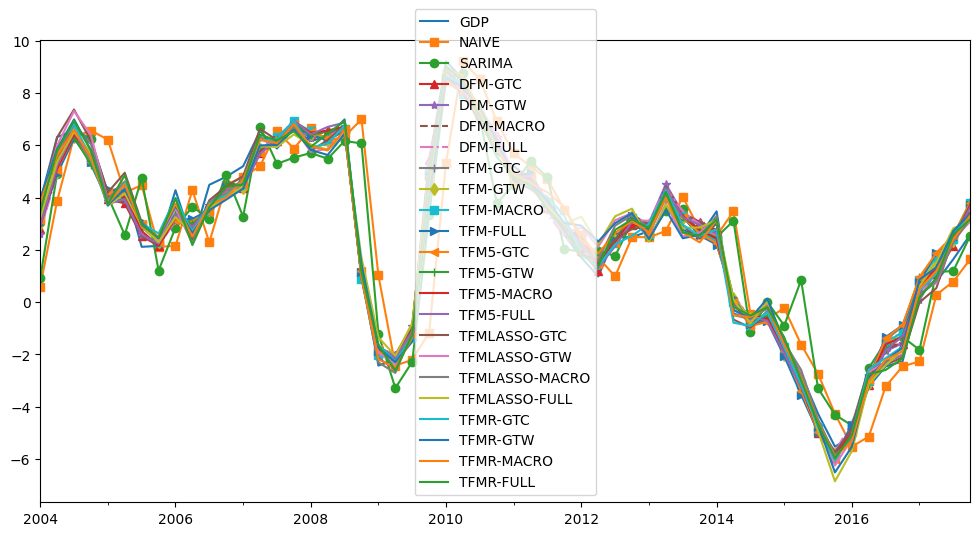

In [151]:
# Previsões IN-SAMPLE

forecasts_insample = pd.DataFrame()
forecasts_insample['GDP'] = y_train
forecasts_insample['NAIVE'] = naive_train.values
forecasts_insample['SARIMA'] = pred_sarima_is.values
forecasts_insample['DFM-GTC'] = dfmgtc_pred
forecasts_insample['DFM-GTW'] = dfmgtw_pred
forecasts_insample['DFM-MACRO'] = dfmmacro_pred
forecasts_insample['DFM-FULL'] = dfmfull_pred
forecasts_insample['TFM-GTC'] = tfmgtc_pred
forecasts_insample['TFM-GTW'] = tfmgtw_pred
forecasts_insample['TFM-MACRO'] = tfmmacro_pred
forecasts_insample['TFM-FULL'] = tfmfull_pred
forecasts_insample['TFM5-GTC'] = tfm5gtc_pred
forecasts_insample['TFM5-GTW'] = tfm5gtw_pred
forecasts_insample['TFM5-MACRO'] = tfm5macro_pred
forecasts_insample['TFM5-FULL'] = tfm5full_pred
forecasts_insample['TFMLASSO-GTC'] = tfmlassogtc_pred
forecasts_insample['TFMLASSO-GTW'] = tfmlassogtw_pred
forecasts_insample['TFMLASSO-MACRO'] = tfmlassomacro_pred
forecasts_insample['TFMLASSO-FULL'] = tfmlassofull_pred
forecasts_insample['TFMR-GTC'] = tfmrobustgtc_pred
forecasts_insample['TFMR-GTW'] = tfmrobustgtw_pred
forecasts_insample['TFMR-MACRO'] = tfmrobustmacro_pred
forecasts_insample['TFMR-FULL'] = tfmrobustfull_pred


# ----

ax = forecasts_insample.plot(figsize=(12,6), style=['-', 's-','o-','^-', '*-','--','-.', '+-', 'd-', 's-', '>-','<-','|-'])

# plt.savefig('all-models-images/GTC-GTW-NEW-ALLMODELS-insample.png')

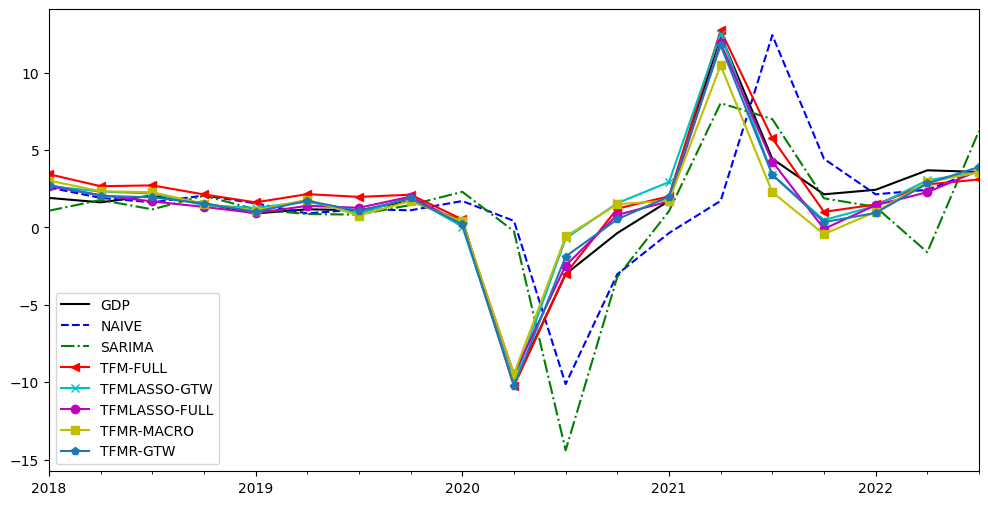

In [152]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample = pd.DataFrame()
forecasts_outsample['GDP'] = y_test
forecasts_outsample['NAIVE'] = naive_test.values
forecasts_outsample['SARIMA'] = pred_sarima_os
forecasts_outsample['DFM-GTC'] = dfmgtc_pred_os
forecasts_outsample['DFM-GTW'] = dfmgtw_pred_os
forecasts_outsample['DFM-MACRO'] = dfmmacro_pred_os
forecasts_outsample['DFM-FULL'] = dfmfull_pred_os
forecasts_outsample['TFM-GTC'] = tfmgtc_pred_os
forecasts_outsample['TFM-GTW'] = tfmgtw_pred_os
forecasts_outsample['TFM-MACRO'] = tfmmacro_pred_os
forecasts_outsample['TFM-FULL'] = tfmfull_pred_os
forecasts_outsample['TFM5-GTC'] = tfm5gtc_pred_os
forecasts_outsample['TFM5-GTW'] = tfm5gtw_pred_os
forecasts_outsample['TFM5-MACRO'] = tfm5macro_pred_os
forecasts_outsample['TFM5-FULL'] = tfm5full_pred_os
forecasts_outsample['TFMLASSO-GTC'] = tfmlassogtc_pred_os
forecasts_outsample['TFMLASSO-GTW'] = tfmlassogtw_pred_os
forecasts_outsample['TFMLASSO-MACRO'] = tfmlassomacro_pred_os
forecasts_outsample['TFMLASSO-FULL'] = tfmlassofull_pred_os
forecasts_outsample['TFMR-GTC'] = tfmrobustgtc_pred_os
forecasts_outsample['TFMR-GTW'] = tfmrobustgtw_pred_os
forecasts_outsample['TFMR-MACRO'] = tfmrobustmacro_pred_os
forecasts_outsample['TFMR-FULL'] = tfmrobustfull_pred_os


# ----

ax = forecasts_outsample[['GDP', 'NAIVE', 'SARIMA', 'TFM-FULL', 'TFMLASSO-GTW', 
                          'TFMLASSO-FULL', 'TFMR-MACRO', 'TFMR-GTW']].plot(figsize=(12,6), 
                                                                           style=['k-', 'b--','g-.', 'r<-', 'cx-', 
                                                                                  'mo-', 'ys-', 'p-'])

plt.savefig('../../paper/plots-tables/OOS-PREDICTIONS.png')

# Métricas

In [153]:
# Naive 

# In-sample 
naive_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['NAIVE']))
naive_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['NAIVE'])
naive_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['NAIVE'])

# Out-of-sample
naive_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['NAIVE']))
naive_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['NAIVE'])
naive_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['NAIVE'])

# -----

# SARIMA(1,0,1)(0,0,2,4)
# In-sample
sarima_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['SARIMA']))
sarima_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['SARIMA'])
sarima_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['SARIMA'])

#Out-of-sample
sarima_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['SARIMA']))
sarima_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['SARIMA'])
sarima_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['SARIMA'])

# ----


# TODOS OS FATORES GTC

# In-sample
dfmgtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTC']))
dfmgtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTC'])
dfmgtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTC'])

#Out-of-sample
dfmgtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTC']))
dfmgtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTC'])
dfmgtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTC'])


# ----


# TODOS OS FATORES GTW

# In-sample
dfmgtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTW']))
dfmgtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTW'])
dfmgtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTW'])

#Out-of-sample
dfmgtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTW']))
dfmgtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTW'])
dfmgtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTW'])

# ---

# ----


# TODOS OS FATORES MACRO

# In-sample
dfmmacro_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM-MACRO']))
dfmmacro_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM-MACRO'])
dfmmacro_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM-MACRO'])

#Out-of-sample
dfmmacro_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-MACRO']))
dfmmacro_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-MACRO'])
dfmmacro_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-MACRO'])

# ---


# TODOS OS FATORES GTC+GTW

# In-sample
dfmfull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM-FULL']))
dfmfull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM-FULL'])
dfmfull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM-FULL'])

#Out-of-sample
dfmfull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-FULL']))
dfmfull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-FULL'])
dfmfull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-FULL'])

# ---


# TFM P-VALOR GTC

# In-sample
tfmgtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTC']))
tfmgtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTC'])
tfmgtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTC'])

#Out-of-sample
tfmgtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTC']))
tfmgtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTC'])
tfmgtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTC'])

# ---


# TFM P-VALOR GTW

# In-sample
tfmgtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTW']))
tfmgtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTW'])
tfmgtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTW'])

#Out-of-sample
tfmgtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTW']))
tfmgtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTW'])
tfmgtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTW'])

# ---

# ---


# TFM P-VALOR MACRO

# In-sample
tfmmacro_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM-MACRO']))
tfmmacro_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM-MACRO'])
tfmmacro_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM-MACRO'])

#Out-of-sample
tfmmacro_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-MACRO']))
tfmmacro_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-MACRO'])
tfmmacro_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-MACRO'])

# ---


# TFM P-VALOR GTC+GTW

# In-sample
tfmfull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM-FULL']))
tfmfull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM-FULL'])
tfmfull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM-FULL'])

#Out-of-sample
tfmfull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-FULL']))
tfmfull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-FULL'])
tfmfull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-FULL'])

# ---


# TFM P-VALOR GTC

# In-sample
tfm5gtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM5-GTC']))
tfm5gtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM5-GTC'])
tfm5gtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM5-GTC'])

#Out-of-sample
tfm5gtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-GTC']))
tfm5gtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-GTC'])
tfm5gtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-GTC'])

# ---


# TFM P-VALOR GTW

# In-sample
tfm5gtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM5-GTW']))
tfm5gtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM5-GTW'])
tfm5gtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM5-GTW'])

#Out-of-sample
tfm5gtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-GTW']))
tfm5gtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-GTW'])
tfm5gtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-GTW'])

# ---

# ---


# TFM P-VALOR MACRO

# In-sample
tfm5macro_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM5-MACRO']))
tfm5macro_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM5-MACRO'])
tfm5macro_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM5-MACRO'])

#Out-of-sample
tfm5macro_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-MACRO']))
tfm5macro_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-MACRO'])
tfm5macro_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-MACRO'])

# ---


# TFM P-VALOR GTC+GTW

# In-sample
tfm5full_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM5-FULL']))
tfm5full_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM5-FULL'])
tfm5full_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM5-FULL'])

#Out-of-sample
tfm5full_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-FULL']))
tfm5full_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-FULL'])
tfm5full_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM5-FULL'])

# ---


# TFMLASSO GTC

# In-sample
tfmlassogtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTC']))
tfmlassogtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTC'])
tfmlassogtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTC'])

#Out-of-sample
tfmlassogtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTC']))
tfmlassogtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTC'])
tfmlassogtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTC'])

# ---

# ---


# TFMLASSO GTW

# In-sample
tfmlassogtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTW']))
tfmlassogtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTW'])
tfmlassogtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTW'])

#Out-of-sample
tfmlassogtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTW']))
tfmlassogtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTW'])
tfmlassogtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTW'])

# ---


# TFMLASSO MACRO

# In-sample
tfmlassomacro_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-MACRO']))
tfmlassomacro_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-MACRO'])
tfmlassomacro_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-MACRO'])

#Out-of-sample
tfmlassomacro_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-MACRO']))
tfmlassomacro_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-MACRO'])
tfmlassomacro_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-MACRO'])

# ---


# TFMLASSO GTC+GTW

# In-sample
tfmlassofull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-FULL']))
tfmlassofull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-FULL'])
tfmlassofull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-FULL'])

#Out-of-sample
tfmlassofull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-FULL']))
tfmlassofull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-FULL'])
tfmlassofull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-FULL'])

# ---


# ---


# TFMR GTC

# In-sample
tfmrobustgtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTC']))
tfmrobustgtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTC'])
tfmrobustgtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTC'])

#Out-of-sample
tfmrobustgtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTC']))
tfmrobustgtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTC'])
tfmrobustgtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTC'])

# ---

# ---


# TFMR GTW

# In-sample
tfmrobustgtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTW']))
tfmrobustgtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTW'])
tfmrobustgtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTW'])

#Out-of-sample
tfmrobustgtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTW']))
tfmrobustgtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTW'])
tfmrobustgtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTW'])

# ---

# ---


# TFMR MACRO

# In-sample
tfmrobustmacro_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMR-MACRO']))
tfmrobustmacro_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMR-MACRO'])
tfmrobustmacro_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMR-MACRO'])

#Out-of-sample
tfmrobustmacro_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-MACRO']))
tfmrobustmacro_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-MACRO'])
tfmrobustmacro_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-MACRO'])

# ---

# ---


# TFMR GTC+GTW

# In-sample
tfmrobustfull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMR-FULL']))
tfmrobustfull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMR-FULL'])
tfmrobustfull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMR-FULL'])

#Out-of-sample
tfmrobustfull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-FULL']))
tfmrobustfull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-FULL'])
tfmrobustfull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-FULL'])

# ---


In [154]:
# FINAL DF

# Definindo variáveis
method = ['NAIVE', 'SARIMA',  
          'DFM-MACRO', 'DFM-GTW', 'DFM-GTC', 'DFM-FULL', 
          'TFM-MACRO', 'TFM-GTW', 'TFM-GTC', 'TFM-FULL', 
          'TFM5-MACRO', 'TFM5-GTW', 'TFM5-GTC', 'TFM5-FULL',
          'TFMLASSO-MACRO', 'TFMLASSO-GTW', 'TFMLASSO-GTC', 'TFMLASSO-FULL', 
          'TFMR-MACRO', 'TFMR-GTW', 'TFMR-GTC', 'TFMR-FULL']

rmse_is = [naive_rmse_is, sarima_rmse_is, 
           dfmmacro_rmse_is, dfmgtw_rmse_is, dfmgtc_rmse_is, dfmfull_rmse_is, 
           tfmmacro_rmse_is, tfmgtw_rmse_is, tfmgtc_rmse_is, tfmfull_rmse_is, 
           tfm5macro_rmse_is, tfm5gtw_rmse_is, tfm5gtc_rmse_is, tfm5full_rmse_is, 
           tfmlassomacro_rmse_is, tfmlassogtw_rmse_is, tfmlassogtc_rmse_is, tfmlassofull_rmse_is, 
           tfmrobustmacro_rmse_is, tfmrobustgtw_rmse_is, tfmrobustgtc_rmse_is, tfmrobustfull_rmse_is]

mae_is = [naive_mae_is, sarima_mae_is, 
          dfmmacro_mae_is, dfmgtw_mae_is, dfmgtc_mae_is, dfmfull_mae_is, 
          tfmmacro_mae_is, tfmgtw_mae_is, tfmgtc_mae_is, tfmfull_mae_is,
          tfm5macro_mae_is, tfm5gtw_mae_is, tfm5gtc_mae_is, tfm5full_mae_is, 
          tfmlassomacro_mae_is, tfmlassogtw_mae_is, tfmlassogtc_mae_is, tfmlassofull_mae_is, 
          tfmrobustmacro_mae_is, tfmrobustgtw_mae_is, tfmrobustgtc_mae_is, tfmrobustfull_mae_is]

mape_is = [naive_mape_is, sarima_mape_is, 
          dfmmacro_mape_is, dfmgtw_mape_is, dfmgtc_mape_is, dfmfull_mape_is, 
          tfmmacro_mape_is, tfmgtw_mape_is, tfmgtc_mape_is, tfmfull_mape_is,
          tfm5macro_mape_is, tfm5gtw_mape_is, tfm5gtc_mape_is, tfm5full_mape_is, 
          tfmlassomacro_mape_is, tfmlassogtw_mape_is, tfmlassogtc_mape_is, tfmlassofull_mape_is, 
          tfmrobustmacro_mape_is, tfmrobustgtw_mape_is, tfmrobustgtc_mape_is, tfmrobustfull_mape_is]

rmse_os = [naive_rmse_os, sarima_rmse_os, 
           dfmmacro_rmse_os, dfmgtw_rmse_os, dfmgtc_rmse_os, dfmfull_rmse_os, 
           tfmmacro_rmse_os, tfmgtw_rmse_os, tfmgtc_rmse_os, tfmfull_rmse_os,
           tfm5macro_rmse_os, tfm5gtw_rmse_os, tfm5gtc_rmse_os, tfm5full_rmse_os, 
           tfmlassomacro_rmse_os, tfmlassogtw_rmse_os, tfmlassogtc_rmse_os, tfmlassofull_rmse_os, 
           tfmrobustmacro_rmse_os, tfmrobustgtw_rmse_os, tfmrobustgtc_rmse_os, tfmrobustfull_rmse_os]

mae_os = [naive_mae_os, sarima_mae_os, 
          dfmmacro_mae_os, dfmgtw_mae_os, dfmgtc_mae_os, dfmfull_mae_os, 
          tfmmacro_mae_os, tfmgtw_mae_os, tfmgtc_mae_os, tfmfull_mae_os,
          tfm5macro_mae_os, tfm5gtw_mae_os, tfm5gtc_mae_os, tfm5full_mae_os, 
          tfmlassomacro_mae_os, tfmlassogtw_mae_os, tfmlassogtc_mae_os, tfmlassofull_mae_os, 
          tfmrobustmacro_mae_os, tfmrobustgtw_mae_os, tfmrobustgtc_mae_os, tfmrobustfull_mae_os]

mape_os = [naive_mape_os, sarima_mape_os, 
          dfmmacro_mape_os, dfmgtw_mape_os, dfmgtc_mape_os, dfmfull_mape_os, 
          tfmmacro_mape_os, tfmgtw_mape_os, tfmgtc_mape_os, tfmfull_mape_os,
          tfm5macro_mape_os, tfm5gtw_mape_os, tfm5gtc_mape_os, tfm5full_mape_os, 
          tfmlassomacro_mape_os, tfmlassogtw_mape_os, tfmlassogtc_mape_os, tfmlassofull_mape_os, 
          tfmrobustmacro_mape_os, tfmrobustgtw_mape_os, tfmrobustgtc_mape_os, tfmrobustfull_mape_os]


metrics_df = pd.DataFrame({'Method':method, 
                           'RMSE_IS': rmse_is,
                           'MAE_IS': mae_is,
                           'MAPE_IS': mape_is,
                           'RMSE_OOS': rmse_os,
                           'MAE_OOS': mae_os,
                           'MAPE_OOS': mape_os
                           })

metrics_df.set_index('Method', inplace = True)
metrics_df = metrics_df.round(3)
metrics_df

,RMSE_IS,MAE_IS,MAPE_IS,RMSE_OOS,MAE_OOS,MAPE_OOS
Method,,,,,,
NAIVE,1.890,1.336,0.796,4.363,2.620,1.136
SARIMA,1.431,1.048,0.676,3.993,2.439,1.224
DFM-MACRO,0.529,0.438,0.200,1.149,0.901,0.817
DFM-GTW,0.534,0.442,0.209,1.179,0.955,0.754
DFM-GTC,0.511,0.424,0.186,1.096,0.871,0.801
DFM-FULL,0.602,0.490,0.231,1.331,1.138,0.915
TFM-MACRO,0.574,0.470,0.249,0.956,0.784,0.687
TFM-GTW,0.567,0.460,0.234,1.042,0.876,0.710
TFM-GTC,0.623,0.510,0.274,0.952,0.818,0.709


In [155]:
metrics_df.shape

(22, 6)

In [156]:
metrics_osdf = metrics_df[['RMSE_OOS', 'MAE_OOS', 'MAPE_OOS']]
metrics_osdf
# print(metrics_osdf.round(3).to_latex())

,RMSE_OOS,MAE_OOS,MAPE_OOS
Method,,,
NAIVE,4.363,2.620,1.136
SARIMA,3.993,2.439,1.224
DFM-MACRO,1.149,0.901,0.817
DFM-GTW,1.179,0.955,0.754
DFM-GTC,1.096,0.871,0.801
DFM-FULL,1.331,1.138,0.915
TFM-MACRO,0.956,0.784,0.687
TFM-GTW,1.042,0.876,0.710
TFM-GTC,0.952,0.818,0.709


In [157]:
metrics_osdf.sort_values(by = 'RMSE_OOS', ascending = True)

,RMSE_OOS,MAE_OOS,MAPE_OOS
Method,,,
TFMR-GTW,0.770,0.582,0.372
TFMLASSO-FULL,0.779,0.553,0.386
TFM-FULL,0.866,0.739,0.587
TFM-GTC,0.952,0.818,0.709
TFM-MACRO,0.956,0.784,0.687
TFM5-GTC,0.957,0.830,0.721
TFMLASSO-GTW,0.963,0.709,0.600
TFM-GTW,1.042,0.876,0.710
DFM-GTC,1.096,0.871,0.801


In [158]:
metrics_osdf.sort_values(by = 'MAE_OOS', ascending = True)

,RMSE_OOS,MAE_OOS,MAPE_OOS
Method,,,
TFMLASSO-FULL,0.779,0.553,0.386
TFMR-GTW,0.770,0.582,0.372
TFMLASSO-GTW,0.963,0.709,0.600
TFM-FULL,0.866,0.739,0.587
TFM-MACRO,0.956,0.784,0.687
TFM-GTC,0.952,0.818,0.709
TFM5-GTC,0.957,0.830,0.721
DFM-GTC,1.096,0.871,0.801
TFM-GTW,1.042,0.876,0.710


In [159]:
metrics_osdf.sort_values(by = 'MAPE_OOS', ascending = True)

,RMSE_OOS,MAE_OOS,MAPE_OOS
Method,,,
TFMR-GTW,0.770,0.582,0.372
TFMLASSO-FULL,0.779,0.553,0.386
TFMR-MACRO,1.254,0.902,0.574
TFM-FULL,0.866,0.739,0.587
TFMLASSO-GTW,0.963,0.709,0.600
TFMR-GTC,1.328,1.028,0.671
TFM-MACRO,0.956,0.784,0.687
TFMLASSO-MACRO,1.391,1.024,0.698
TFM-GTC,0.952,0.818,0.709


In [160]:
metrics_oos = metrics_df[['RMSE_OOS', 'MAE_OOS', 'MAPE_OOS']].copy()
metrics_oos_share = metrics_oos.copy()
metrics_oos_share['RMSE'] = metrics_oos_share['RMSE_OOS'] / metrics_oos_share['RMSE_OOS'].loc['SARIMA']
metrics_oos_share['MAE'] = metrics_oos_share['MAE_OOS'] / metrics_oos_share['MAE_OOS'].loc['SARIMA']
metrics_oos_share['MAPE'] = metrics_oos_share['MAPE_OOS'] / metrics_oos_share['MAPE_OOS'].loc['SARIMA']
metrics_oos_share.drop(['RMSE_OOS', 'MAE_OOS', 'MAPE_OOS'], axis = 1, inplace = True)
metrics_oos_share.drop('SARIMA', axis = 0, inplace=True)
metrics_oos_share.round(3)

,RMSE,MAE,MAPE
Method,,,
NAIVE,1.093,1.074,0.928
DFM-MACRO,0.288,0.369,0.667
DFM-GTW,0.295,0.392,0.616
DFM-GTC,0.274,0.357,0.654
DFM-FULL,0.333,0.467,0.748
TFM-MACRO,0.239,0.321,0.561
TFM-GTW,0.261,0.359,0.580
TFM-GTC,0.238,0.335,0.579
TFM-FULL,0.217,0.303,0.480


# Novas visualizações

In [161]:
metrics_oos.reset_index(inplace=True)
factors_metrics = metrics_df.iloc[2:]
factors_metrics['data'] = [ 'MACRO', 'GTW', 'GTC', 'FULL',
                       'MACRO', 'GTW', 'GTC', 'FULL',
                       'MACRO', 'GTW', 'GTC', 'FULL',
                       'MACRO', 'GTW', 'GTC', 'FULL',
                       'MACRO', 'GTW', 'GTC', 'FULL']
factors_metrics['method'] = [ 'DFM', 'DFM', 'DFM', 'DFM',
                       'TFM', 'TFM', 'TFM', 'TFM',
                       'TFM5', 'TFM5', 'TFM5', 'TFM5',
                       'TFMLASSO', 'TFMLASSO', 'TFMLASSO', 'TFMLASSO',
                       'TFMR', 'TFMR', 'TFMR', 'TFMR']
factors_metrics.reset_index(inplace=True)
factors_metrics

,Method,RMSE_IS,MAE_IS,MAPE_IS,RMSE_OOS,MAE_OOS,MAPE_OOS,data,method
0,DFM-MACRO,0.529,0.438,0.200,1.149,0.901,0.817,MACRO,DFM
1,DFM-GTW,0.534,0.442,0.209,1.179,0.955,0.754,GTW,DFM
2,DFM-GTC,0.511,0.424,0.186,1.096,0.871,0.801,GTC,DFM
3,DFM-FULL,0.602,0.490,0.231,1.331,1.138,0.915,FULL,DFM
4,TFM-MACRO,0.574,0.470,0.249,0.956,0.784,0.687,MACRO,TFM
5,TFM-GTW,0.567,0.460,0.234,1.042,0.876,0.710,GTW,TFM
6,TFM-GTC,0.623,0.510,0.274,0.952,0.818,0.709,GTC,TFM
7,TFM-FULL,0.649,0.533,0.280,0.866,0.739,0.587,FULL,TFM
8,TFM5-MACRO,0.539,0.447,0.212,1.125,0.956,0.815,MACRO,TFM5
9,TFM5-GTW,0.533,0.442,0.206,1.145,1.019,0.787,GTW,TFM5


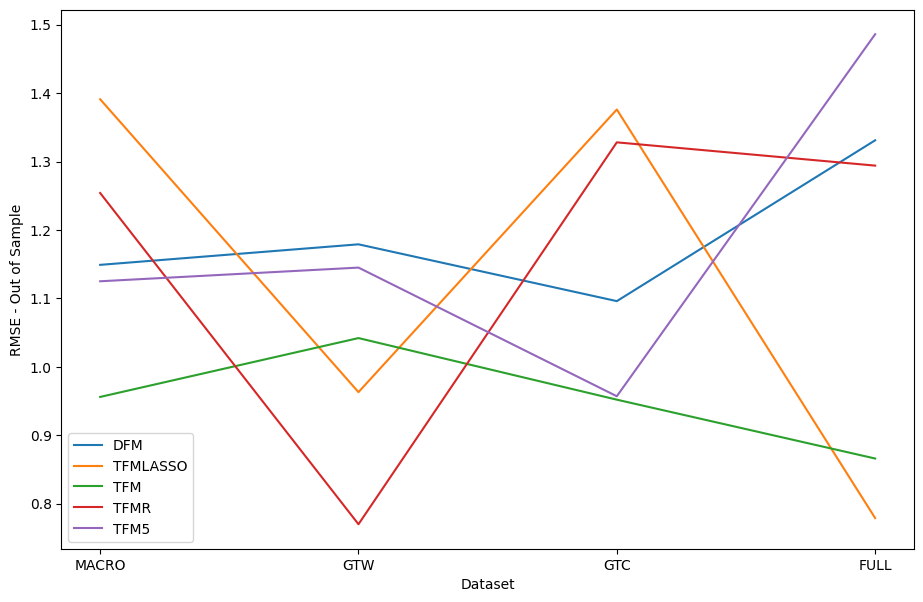

In [166]:
rmse_factor_metrics = factors_metrics[['data', 'method', 'RMSE_OOS']].copy()
rmse_factor_metrics.sort_values(['data'], ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(11,7))
sns.lineplot(x="data", y="RMSE_OOS", hue = "method", data=rmse_factor_metrics)
ax.set_title('', fontsize=20)
ax.set_xlabel('Dataset', fontsize=10)
ax.set_ylabel('RMSE - Out of Sample', fontsize=10)
plt.legend(loc='lower left')
plt.show()
fig.savefig('../../paper/plots-tables/RMSE_OOS_GRAPH.png')

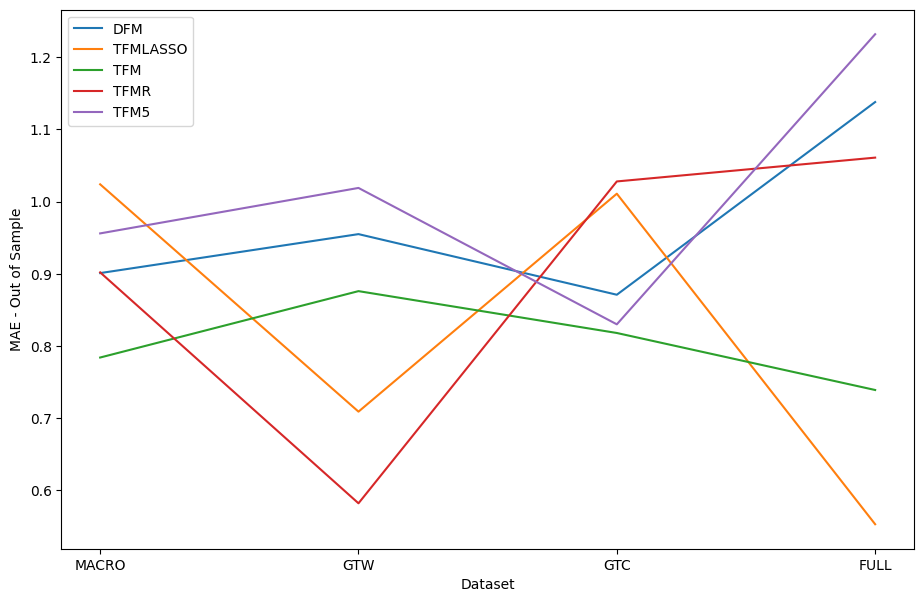

In [167]:
mae_factor_metrics = factors_metrics[['data', 'method', 'MAE_OOS']].copy()
mae_factor_metrics.sort_values(['data'], ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(11,7))
sns.lineplot(x="data", y="MAE_OOS", hue = "method", data=mae_factor_metrics)
ax.set_title('', fontsize=20)
ax.set_xlabel('Dataset', fontsize=10)
ax.set_ylabel('MAE - Out of Sample', fontsize=10)
plt.legend(loc='upper left')
plt.show()
fig.savefig('../../paper/plots-tables/MAE_OOS_GRAPH.png')

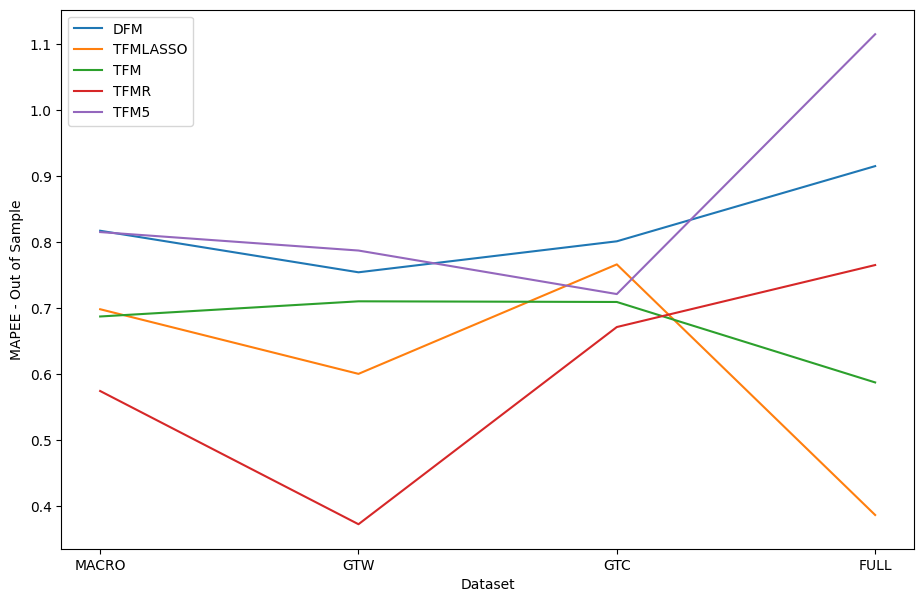

In [168]:
mape_factor_metrics = factors_metrics[['data', 'method', 'MAPE_OOS']].copy()
mape_factor_metrics.sort_values(['data'], ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(11,7))
sns.lineplot(x="data", y="MAPE_OOS", hue = "method", data=mape_factor_metrics)
ax.set_title('', fontsize=20)
ax.set_xlabel('Dataset', fontsize=10)
ax.set_ylabel('MAPEE - Out of Sample', fontsize=10)
plt.legend(loc='upper left')
plt.show()
fig.savefig('../../paper/plots-tables/MAPE_OOS_GRAPH.png')